# DSCI 614 Text Mining
## Topic Model



**Objectives**


After you complete this module, students will be able to:

+ Clean and preprocess the texts.
+ Perform Latent Dirichlet Allocation (LDA) algorithm based on CountVectorizer.
+ Perform Latent Dirichlet Allocation (LDA) algorithm based on TfidfVectorizer.
+ Find the top words for each topic and visualize them.
+ Visualize the topic Model using pyLDAvis.


We covered the text classification that is supervised learning in the previous week. We will cover the topic model this week. It is an **unsupervised machine learning method without a label for text data**. First, we will load and clean the texts. Secondly,  I will show you how to build LDA models using sklearn. Second, we will visualie the top words for each topic. Finally, we will cover how to plot the topic models using dimensiona reduction techinques such as PCA and t-SNE.

Withou a label, it is very hard for us to check the models.


**Readings**

+ Latent Dirichlet allocation (https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
+ Latent Dirichlet Allocation with online variational Bayes algorithm (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
+ PyLDAvis: Python library for interactive topic model visualization (https://github.com/bmabey/pyLDAvis)









# The Twitter US Airline 

You have given a Twitter US Airline sentiment dataset containing in Tweets.csv (https://www.kaggle.com/crowdflower/twitter-airline-sentiment/), which is a comma-separated file. It has the following columns:

+ tweet_id
+ airline_sentiment
+ airline_sentiment_confidence
+ negativereason
+ negativereason_confidence
+ airline
+ airline_sentiment_gold
+ name
+ negativereason_gold
+ retweet_count
+ text
+ tweet_coord
+ tweet_created
+ tweet_location
+ user_timezone

This project aims to **build topic models on the text data without the label**.
 
 
Let's load the dataset into memory using the pandas library. 


## Clean and Preprocess the Data

In [1]:

import pandas as pd
import warnings
warnings.filterwarnings("ignore")

twitter_airline=pd.read_csv('Tweets.csv')
twitter_airline.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Let's select all the text features (without the label) from the dataset.

In [2]:
#twitter_airline = twitter_airline[["airline", "airline_sentiment", "negativereason", "airline_sentiment_gold", "negativereason_gold", "text" ]]
twitter_airline = twitter_airline[["airline", "negativereason", "airline_sentiment_gold", "negativereason_gold", "text" ]]

Let's check the missing values in this dataset.

In [3]:
twitter_airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   airline                 14640 non-null  object
 1   negativereason          9178 non-null   object
 2   airline_sentiment_gold  40 non-null     object
 3   negativereason_gold     32 non-null     object
 4   text                    14640 non-null  object
dtypes: object(5)
memory usage: 572.0+ KB


In [4]:
percent_missing = twitter_airline.isnull().sum() * 100 / len(twitter_airline)
percent_missing

airline                    0.000000
negativereason            37.308743
airline_sentiment_gold    99.726776
negativereason_gold       99.781421
text                       0.000000
dtype: float64

Let's concatenate all the texts into the feature of text_review.

In [5]:
text_cols = ["negativereason", "airline_sentiment_gold", "negativereason_gold", "text" ]
twitter_airline['text_review'] = twitter_airline[text_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

We select the columns to perform our analysis.

In [6]:
twitter_airline = twitter_airline[['airline', 'text_review']]

Next, we want to clean the text_review column using regular expression and Spacy library. 
We first remove nan, @airline, punctuation, URL, or any non-alphanumeric characters and separate word using a single space. Then we remove stop words and obtain the lemma of the tokens/words. 

In [7]:
import re
import string
import spacy


# Load the small model
nlp = spacy.load("en_core_web_sm")

stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Creating our tokenzer function from a given sentence/review
def clean_text(sentence):
    # Remove nan, @airline, punctuation, URL, or any non alpanumeric characters and seperate word using a single space.
    sentence = ' '.join(re.sub("(nan)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence).split())
    # Removing stop words and obtain the lemma
    text = [ word.lemma_ for word in nlp(sentence) if word not in stop_words]
    return ' '.join(text).strip().lower()

# Apply clean_text function to the column.
twitter_airline['text_review_cleaned'] = twitter_airline['text_review'].apply(clean_text)

Let's look at the cleaned dataset.

In [8]:
twitter_airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   airline              14640 non-null  object
 1   text_review          14640 non-null  object
 2   text_review_cleaned  14640 non-null  object
dtypes: object(3)
memory usage: 343.2+ KB


In [9]:
percent_missing = twitter_airline.isnull().sum() * 100 / len(twitter_airline)
percent_missing

airline                0.0
text_review            0.0
text_review_cleaned    0.0
dtype: float64

In [10]:
twitter_airline.head(5)

,airline,text_review,text_review_cleaned
0,Virgin America,nan nan nan @VirginAmerica What @dhepburn said.,what say
1,Virgin America,nan nan nan @VirginAmerica plus you've added c...,plus you ve add commercial to the experience t...
2,Virgin America,nan nan nan @VirginAmerica I didn't today... M...,i didn t today must mean i need to take anothe...
3,Virgin America,Bad Flight nan nan @VirginAmerica it's really ...,bad flight it s really aggressive to blast obn...
4,Virgin America,Can't Tell nan nan @VirginAmerica and it's a r...,can t tell and it s a really big bad thing abo...


## Latent Dirichlet Allocation (LDA) Algorithm based on CountVectorizer

The Latent Dirichlet Allocation (LDA) is a generative probabilistic model for a collection of text documents such as a corpus. It is used the Bayesian approach and EM algorithm to estate the parameters. Please read the paper: Latent Dirichlet Allocation (https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) for detailed information.

Let's develop our first Latent Dirichlet Allocation (LDA) Algorithm based on CountVectorizer. To perform LDA, we first need to construct a document word matrix using either CountVectorizer or TfidfVectorizer.

When we create a document word matrix, there are many hyper parameters to set. Please see the help document (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for detailed information. For illustration purposes, we set the following hyperparameters:

+ **max_df**: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.
+ **min_df**: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.
+ **stop_words** : {‘english’}, list, default=None
If ‘english’, a built-in stop word list for English is used. There are several known issues with ‘english’ and you should consider an alternative (see Using stop words). If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens. Only applies if analyzer == 'word'. If None, no stop words will be used. max_df can be set to a value in the range [0.7, 1.0) to automatically detect and filter stop words based on intra corpus document frequency of terms.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.90, min_df=5, stop_words='english')
# Create document word matrix by converting the cleaned text to a numerical matrxi
# then the engine can work on the numerical matrix
document_word_matrix_tf = tf_vectorizer.fit_transform(twitter_airline['text_review_cleaned'])

After we generate the document word matrix, we can perform LDA analysis on it. Latent Dirichlet Allocation algorithm has several parameters to specify. Please see the official help document (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) for detailed information.

In [12]:
from sklearn.decomposition import LatentDirichletAllocation

# Specify the number of topics using n_components and fix the seed
# You, the data scientist should justify the n_components; in theory, we can put any number here, such as 99, 101
# in practice, it must make sense; for example, we choose 4, whih means, we have outstanding, very good, neural, negative reviews.

# there is no closed form solution, we have to use numerical algorithm based on probablity distribution
# if we have "enought time", everyone has the "same results"
# in practice, it doesn't work due to the limits of resource such as hardware and time
# we need to fix the seeds, then everyone can produce the "same results"
lda = LatentDirichletAllocation(n_components= 4 ,random_state= 101)
# then we fit this LDA model on the word matrix
lda.fit(document_word_matrix_tf)

LatentDirichletAllocation(n_components=4, random_state=101)

## Top Words for Each Topic

LDA algorithm has one crucial attribute of **components_**. It is a **two-dimensional vector**. I summarize it as follows:

+ The row denotes the topics. We specified four topics. Therefore it has four rows.
+ The column represents the document words generated from either CountVectorizer or TfidfVectorizer.

It can also be viewed as **a distribution over the words for each topic after normalization**. Therefore the **top words have the largest values/probabilities**.

Let's look at how many words/tokens in the matrix since we set max_df =0.90, min_df =5 and stop_word ="english". The engine already helped us remove the following words from the document and corpus
+ stop words
+ words appear in at least 90% of the documents/reviews
+ rare words that only appear less than 5 times in all doucments



In [13]:
len(tf_vectorizer.get_feature_names())

2323

LAD componets_ attribute/data memeber is a 2D array with 4 rows(specified by us) and 2330 words left(see above)

In [14]:
lda.components_.shape

(4, 2323)

Let's print our the top 15 words for each topic.

In [15]:
#"Check" the models by looking at the original words to make sure it makes sense to human/data scientists
n_top_words = 15 
# Loop over each topic:lda.components_ = 4 (specified)
# in the loop the index denote the topic number 0, 1,2, 3
# topics is a row vector with 2330 words and corresponding probablities
for index,topic in enumerate(lda.components_):
    print(f'THE TOP {n_top_words} WORDS FOR TOPIC #{index}')
    # Get the top word for a given topics using list comprehension
    # We rank the values using argsort and take out the corresponding indices
    # Finally obtain the corresponding feature names (word) using the indices
    # argsort sorted the values from smallest to largest; therefore the top values in the end
    # argsort returns the corresponding indices
    # https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
    # after we have the corresponding index, then we can get the feature names(words)
    print([tf_vectorizer.get_feature_names()[j] for j in topic.argsort()[-n_top_words:]])
    #Seperate each topic using #
    print('#'*150)

THE TOP 15 WORDS FOR TOPIC #0
['follow', 'don', 'guy', 'experience', 'look', 'send', 'good', 'dm', 'like', 'just', 'airline', 'fly', 'bad', 'tell', 'thank']
######################################################################################################################################################
THE TOP 15 WORDS FOR TOPIC #1
['ve', 'need', 'say', 'reservation', 'time', 'agent', 'wait', 'try', 'hour', 'help', 'phone', 'hold', 'issue', 'customer', 'service']
######################################################################################################################################################
THE TOP 15 WORDS FOR TOPIC #2
['airport', 'just', 'need', 'ticket', 'fly', 'baggage', 'tell', 'love', 'check', 'great', 'lose', 'thank', 'lost', 'bag', 'luggage']
######################################################################################################################################################
THE TOP 15 WORDS FOR TOPIC #3
['miss', 'complaints', 'wait', 't

# stop here 10/11

Next, we want to visualize the top 15 words for each topic. The following function is taken from Scikit learn official help document(https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py). 

In [16]:
#Check our models by visulize the top words/tokens
import matplotlib.pyplot as plt
#define the function to plot;
# model results,feature_names(tokens/words);n_top_words(specified); title (of the graph)
def plot_top_words(model, feature_names, n_top_words, title):
    # We specify 4 topics BEFORE, then we setup the number of subplot =2*2 
    # the numbers(rows and columns) in the subplots must be adjusted according the given numbers 4;
    # if we specify 6 topics; plt.subplots(3, 2 or plt.subplots(2, 3; plt.subplots(6, 1, etc.
    fig, axes = plt.subplots(2, 2, figsize=(30, 15), sharex=True)
    # Flatten the axes (2 dimensions (2,2), it needs nested loops for rows and columns) to 1 D vector, 
    #then we can loop it easily using one loop instead of using a nested loop for rows and columns
    axes = axes.flatten()
    
    # Loop over all the topics that is = 4 in our example
    # get the corresponding topic index and topic
    for topic_idx, topic in enumerate(model.components_):
        # Rank the values and take out the corresponding  top indices that is in the end of the vector
        # since it ranks from the smallest to the largest 
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        # Take out the top features using the indices
        top_features = [feature_names[i] for i in top_features_ind]
        # Get the weights using fancy indexing
        weights = topic[top_features_ind]
        # Take out the axes of the subplots from the flattened 1D vector
        # it happens to be the index of the topics
        ax = axes[topic_idx]
        #Horizontal bar plot of feature names and corresponding values
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.invert_yaxis.html
        # You may comment out the following code to see the differences; then choose the format you like
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        # Remove the top, right and left axis in matplotlib
        # You may comment out the folowing loop to see the differences
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        #set the tile for all the graphs
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

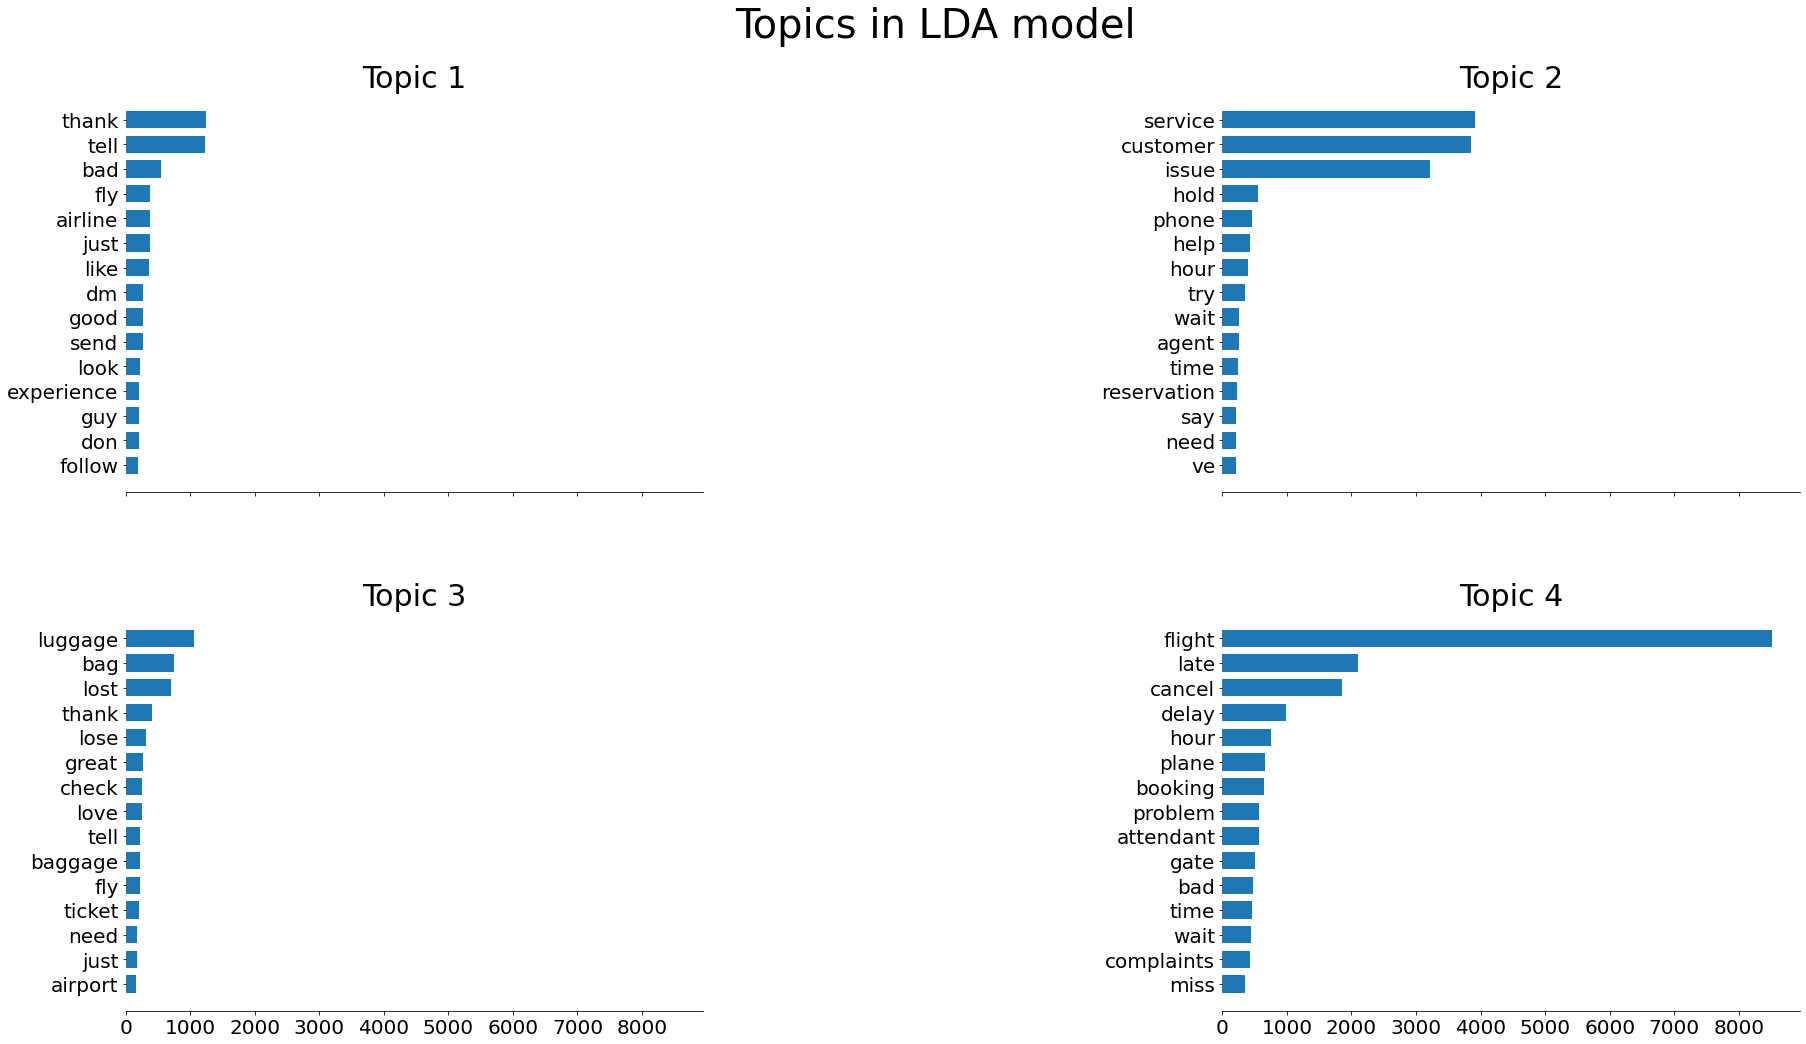

In [17]:
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

## Assign topics ID to Each Document

Let us transform the data of document_word_matrix according to the fitted model. The result is a 2-dimensional vector. **The row denotes the document/review, and the column is the topic ID**. The corresponding values are the probabilities belonging to each topic for a given document/review.

In [18]:
# we predict the topic ID using transform method on the nuemrical matrix obtained from tf-idf
topics = lda.transform(document_word_matrix_tf)
# there are 14640 rows/tweets, 4 columns ( 4 topics), each number dentoes the probablity belong
# to that topics
topics.shape

(14640, 4)

Let's look at the probabilities of each topic for the first document/review. It is easy for us to see that.

+ The sum of these probabilities is 1.
+ The largest number is the 4th number. Therefore, it is assigned to the 4th topic.

In [19]:
topics[0]

array([0.1297348 , 0.61126405, 0.12930114, 0.12970002])

Finally, we assign the topic ID to each document/review by taking out the index of the largest probability.

In [20]:
# Create a new column and save the predicted topic ID
# https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
# Returns the indices of the maximum values along an axis.
# array([0.12969949, 0.13391997, 0.13491871, 0.60146184])
# the returned value for the vector above is 3 since 0.60146184 is the largest value and the corresponding index is 3
twitter_airline['Topic'] = topics.argmax(axis=1)

Let's check the distribution of the topics

In [21]:
twitter_airline['Topic'].value_counts()

3    5133
1    3362
0    3307
2    2838
Name: Topic, dtype: int64

## Topic Modeling Visualization using pyLDAvis

According to the official GitHub of the pyLDAvis:

pyLDAvis is a  Python library for interactive topic model visualization. It is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization. The visualization is intended to be used within an IPython notebook but can also be saved to a stand-alone HTML file for easy sharing.

https://github.com/bmabey/pyLDAvis

To use pyLDAvis, we need to install it in the Anaconda Prompt using the following command:

<center>  pip install pyldavis </center>

### Latent Dirichlet Allocation (LDA) Algorithm using TfidfVectorizer
We are using the TfidfVectorizer to create the Latent Dirichlet Allocation (LDA) model in this section. It is very similar to the Latent Dirichlet Allocation (LDA) Algorithm based on CountVectorizer before.


In [22]:

# convert reviews/texts to numerical vectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Generate the document word matrix using tfidf
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', # Remove the stop words
                                lowercase = True, # Convert the tokes to lower cases
                                # Specif the token using regular expression to consider tokens of 2 for more alphanumeric characters
                                token_pattern = r'\b[a-zA-Z0-9]{2,}\b', 
                                max_df = 0.9, 
                                min_df = 5)
# We build the model on the text reviews only (there is no label inputs at all)
document_word_matrix_tf_idf = tfidf_vectorizer.fit_transform(twitter_airline['text_review_cleaned'])


In [23]:

# Build the LDA model and specify the number of topics; which should justify this number
lda_tf_idf = LatentDirichletAllocation(n_components= 4, random_state= 101)
#lda algorithm fits on the numerical matrix transformed from text reviews using tf-idf or tf method
lda_tf_idf.fit(document_word_matrix_tf_idf)


LatentDirichletAllocation(n_components=4, random_state=101)

### Visualize Topic Modeling using pyLDAvis

PyLDAvis is a port of the fabulous R package of LDAvis by Carson Sievert and Kenny Shirley. LDAvis is summarized in the paper LDAvis: A method for visualizing and interpreting topics. (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

We are using pyLDAvis.sklearn.prepare function to plot it. This funciton has four important parameters as follows:

+ **lda_model** : sklearn.decomposition.LatentDirichletAllocation.
        Latent Dirichlet Allocation model from sklearn fitted with `dtm`
+ **dtm** : array-like or sparse matrix, shape=(n_samples, n_features)
        Document-term matrix used to fit on LatentDirichletAllocation model (`lda_model`)
+ **vectorizer** : sklearn.feature_extraction.text.(**CountVectorizer, TfIdfVectorizer**).
        vectorizer used to convert raw documents to document-term matrix (`dtm`)
+ **mds** :function or a string representation of function. A function that takes topic_term_dists as an input and outputs a n_topics by 2 distance matrix. The output approximates the distance between topics. See js_PCoA() for details on the default function. A string representation currently accepts: see https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html
    + **pcoa** (or upper case variant): Principal Coordinates Analysis 
    + **mmds** (or upper case variant), if sklearn package is installed 
    + **tsne** (or upper case variant), if sklearn package is installed

In [24]:
import pyLDAvis
import pyLDAvis.sklearn
# Enable automatic D3 display of prepared model data in the IPython notebook.
pyLDAvis.enable_notebook()

# Visualize topic model with default mds='pcoa'
# the first argument is easy to set; but for the 2nd and 3rd make sure that we don't mess them up
# the 2nd is the numberical matrix; the 3rd is the TfidfVectorizer object
pyLDAvis.sklearn.prepare(lda_model = lda_tf_idf, dtm = document_word_matrix_tf_idf, vectorizer = tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.209778 -0.017193       1        1  33.512349
0      0.126768 -0.101042       2        1  24.772504
1      0.025097 -0.071754       3        1  24.707359
2      0.057913  0.189989       4        1  17.007788, topic_info=          Term        Freq       Total Category  logprob  loglift
2070     thank  528.000000  528.000000  Default  30.0000  30.0000
415     cancel  336.000000  336.000000  Default  29.0000  29.0000
1241      late  360.000000  360.000000  Default  28.0000  28.0000
614   customer  593.000000  593.000000  Default  27.0000  27.0000
1882   service  599.000000  599.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
638        day   25.867280  137.644785   Topic4  -5.5168   0.0998
614   customer   29.394674  593.730320   Topic4  -5.3890  -1.2341
1209      just   25.416355  221.370665   Topic4  -5.5344  -0.3929
292        bad   25.078595  222.870856   Topic4  -5.5478  -0.4131
180    airline   24.141631  140.404117   Topic4  -5.5858   0.0109

[289 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         4  0.914890       000
131       2  0.939329  absolute
163       3  0.968104  advisory
169       1  0.236055     agent
169       2  0.103864     agent
...     ...       ...       ...
2311      1  0.199484       yes
2311      2  0.077577       yes
2311      3  0.609534       yes
2311      4  0.110824       yes
2316      2  0.970043        yr

[490 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])



**The left panel**, labeled Intertopic Distance Map:
+ Circles represent different topics and the distance between them. Similar topics appear closer and dissimilar topics farther. 
+ The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus. 
+ An individual topic may be selected for closer scrutiny by clicking on its circle or entering its number in the "selected topic" box in the upper-left.

**The right panel**, including the bar chart of the top 30 terms. 
+ When no topic is selected in the plot on the left, the bar chart shows the top-30 most "salient" terms in the corpus. 
+ A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics. Global view before we select any topic( in other words, it consider all the topics0
$$ \text{saliency(term w)}= \text{freqency(w)}*\sum_tp(t|w)*log(p(t|w)/p(t))$$
+ Selecting each topic on the left, modifies the bar chart to show the "relevant" terms for the selected topic. It is used to rank
terms within topics.
Relevance is defined as in footer 2. It is the local view for a given topic

$$ \text{relevance(term w| topic t)}= \lambda*p(w|t)+(1-\lambda)*p(w|t)/p(w)$$

Where $ \lambda$ determines the weight given to the probability of term w under topic t relative to its lift
(measuring both on the log scale). Setting $\lambda =1$
results in the familiar ranking of terms in decreasing order of their topic-specific probability, and
setting $\lambda =0$  ranks terms solely by their lift.

It can be tuned by the parameter $\lambda$.
+ Smaller $\lambda$, gives higher weight to the term's distinctiveness 
+ While larger $\lambda$, corresponds to the probability of the term occurrence per topic.

Therefore, to get a better sense of terms per topic, we'll use $\lambda =0$. 

### Use Different Multidimensional Scaling (MDS) Functions

With sklearn installed, other MDS functions, such as MMDS and TSNE can be used for plotting if the default PCoA is not satisfactory.


+ **Metric Multidimensional Scaling (MMDS)**

    https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling

+ **t-distributed Stochastic Neighbor Embedding (TSNE)**

    https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne

In [25]:
pyLDAvis.sklearn.prepare(lda_model = lda_tf_idf, dtm = document_word_matrix_tf_idf, vectorizer = tfidf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.184032  0.098309       1        1  33.512349
0      0.060245 -0.180493       2        1  24.772504
1     -0.136938 -0.084235       3        1  24.707359
2     -0.107339  0.166419       4        1  17.007788, topic_info=          Term        Freq       Total Category  logprob  loglift
2070     thank  528.000000  528.000000  Default  30.0000  30.0000
415     cancel  336.000000  336.000000  Default  29.0000  29.0000
1241      late  360.000000  360.000000  Default  28.0000  28.0000
614   customer  593.000000  593.000000  Default  27.0000  27.0000
1882   service  599.000000  599.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
638        day   25.867280  137.644785   Topic4  -5.5168   0.0998
614   customer   29.394674  593.730320   Topic4  -5.3890  -1.2341
1209      just   25.416355  221.370665   Topic4  -5.5344  -0.3929
292        bad   25.078595  222.870856   Topic4  -5.5478  -0.4131
180    airline   24.141631  140.404117   Topic4  -5.5858   0.0109

[289 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         4  0.914890       000
131       2  0.939329  absolute
163       3  0.968104  advisory
169       1  0.236055     agent
169       2  0.103864     agent
...     ...       ...       ...
2311      1  0.199484       yes
2311      2  0.077577       yes
2311      3  0.609534       yes
2311      4  0.110824       yes
2316      2  0.970043        yr

[490 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [26]:
pyLDAvis.sklearn.prepare(lda_model = lda_tf_idf, dtm = document_word_matrix_tf_idf, vectorizer = tfidf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      269.562408 -124.803398       1        1  33.512349
0        1.782994 -295.079681       2        1  24.772504
1      220.811432 -343.832123       3        1  24.707359
2       50.533993  -76.050934       4        1  17.007788, topic_info=          Term        Freq       Total Category  logprob  loglift
2070     thank  528.000000  528.000000  Default  30.0000  30.0000
415     cancel  336.000000  336.000000  Default  29.0000  29.0000
1241      late  360.000000  360.000000  Default  28.0000  28.0000
614   customer  593.000000  593.000000  Default  27.0000  27.0000
1882   service  599.000000  599.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
638        day   25.867280  137.644785   Topic4  -5.5168   0.0998
614   customer   29.394674  593.730320   Topic4  -5.3890  -1.2341
1209      just   25.416355  221.370665   Topic4  -5.5344  -0.3929
292        bad   25.078595  222.870856   Topic4  -5.5478  -0.4131
180    airline   24.141631  140.404117   Topic4  -5.5858   0.0109

[289 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         4  0.914890       000
131       2  0.939329  absolute
163       3  0.968104  advisory
169       1  0.236055     agent
169       2  0.103864     agent
...     ...       ...       ...
2311      1  0.199484       yes
2311      2  0.077577       yes
2311      3  0.609534       yes
2311      4  0.110824       yes
2316      2  0.970043        yr

[490 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

# Summary

+ We create a topic model using LDA and CountVectorizer.
+ We create a topic model using LDA and TfidfVectorizer.
+ We visualize the top words in each topic.
+ We visualize topic modeling using pyLDAvis.







# Weekly Assignments:

# Week 8: Project 8 

**Assignment Development Feedback** 
Remember, the weekly assignments in this course are intentionally complex. All of the skills and knowledge needed to complete the assignments has been woven into the course modules, but I am not teaching directly to the assignments. Instead, I am asking you to pull together the pieces of the puzzle which will help you solve the problem. It is important you DO NOT PROCRASTINATE. I am here to support you, but timely feedback requires you to work proactively. 

At any time during week 8, you may submit the Jupyter Notebook, draft files, etc., along with specific questions related to the development of this assignment. The goal is not for me to "pre-grade" your work, but offer guidance and point you in the right direction. I encourage you to make use of this opportunity to refine and develop your work. Refer to my Instructor Introduction and the Course Syllabus for the best ways to contact me, in order to get feedback, and expected response times. 

**For the purposes of this assignment, use Jupyter Notebook**.

Your submission should have one file. This file should be the JupyterNotebook and it should be saved like "Project6_LastName_FirstName.ipynb" (notice the .ipynb as the file extension of the JupyterNotebook script). You need to add the narrative and run the cells and get the corresponding output for each cell.

Assignment:

<font color='red'> **For each question make sure that your work is not repeating something in the course modules or the textbook. Each response must be original and your own submission. You are strictly prohibited from having another person(s) write, review or edit your solution.  Failure to follow this may result in a failing grade.** </font>



You are a data scientist working for a Consulting Firm. You are given a dataset containing in sentiment140.csv. The data set has six columns **without header**:

0. - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1. - the id of the tweet (2087)
2. - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3. - the query (lyx). If there is no query, then this value is NO_QUERY.
4. - the user that tweeted (robotickilldozr)
5. - the text of the tweet ("Lyx is cool")

Data source: http://help.sentiment140.com/for-students

Our goal is to **build topic model on the text of the tweet**.



Q1. Load the dataset of sentiment140.csv into memory.

Q2. Clean and preprocess the texts.

Q3  Generate the first topic model by setting 5 topics using LDA method and **CountVectorizer**.

Q4. Plot the top 20 words for each topic for the model above.


Q5  Generate the second topic model by setting 5 topics using LDA method and **TfidfVectorizer**.

Q6. Plot the top 20 words for each topic for the second model above.


Q7. Visualize the first topic model using dimension reduction method of Principal Coordinate Analysis(aka Classical Multidimensional Scaling.

Q8. Visualize the first topic model using dimension reduction method of t-distributed Stochastic Neighbor Embedding.







# **Grading policies on project:**

This is the rubric the instructor use to grade the projects. This allowed for fine but clear distinctions in evaluating the students’ projects.

+ **Python Codes and Style in the Code Cells**

    + 15 pts: Python codes are easier to read, share, and verify. There are comments in the codes. There are no bugs in the script.
    + 12 pts: Pyton codes are easier to read, share, and verify. There are few comments. There are less than 3 bugs in the script.
    + 9 pts: Python codes could be read. There is no comment. There are less than 4 bugs in the script.
    + 6 pts: Python codes are hard to read. There is no comment. There are more than 5 bugs in the script
    + 3 pts: Python codes are hard to read. There is no comments. There are more than 5 bugs in the script.
+ **Interpretation and Use of Model in the Markdown Cells**
    + 10 pts: The data and model is accurately interpreted to justify the answer, and sufficient data and model is used to defend the main argument.
    + 8 pts: The data and model is accurately interpreted to justify the answer, and model is used to defend the main argument, but it might not be sufficient.
    + 6 pts: Data and model is used to defend the main argument, but it is not accurately interpreted the idea and model, and it might not be sufficient.
    + 4 pts: Data and model is used to defend the main argument, but it is insufficient
    + 2 pts: Data and model is provided, but it is not used to defend the main argument.




# Final Project

**Assignment Development Feedback** 
Remember, the final assignments in this course are intentionally complex. All of the skills and knowledge needed to complete the assignments has been woven into the course modules, but I am not teaching directly to the assignments. Instead, I am asking you to pull together the pieces of the puzzle which will help you solve the problem. It is important you DO NOT PROCRASTINATE. I am here to support you, but timely feedback requires you to work proactively. 

At any time during week 8, you may submit the Jupyter Notebook, draft files, etc., along with specific questions related to the development of this assignment. The goal is not for me to "pre-grade" your work, but offer guidance and point you in the right direction. I encourage you to make use of this opportunity to refine and develop your work. Refer to my Instructor Introduction and the Course Syllabus for the best ways to contact me, in order to get feedback, and expected response times. 

**For the purposes of this assignment, use Jupyter Notebook**.

Your submission should have one file. This file should be the JupyterNotebook and it should be saved like "Final_LastName_FirstName.ipynb" (notice the .ipynb as the file extension of the JupyterNotebook script). You need to add the narrative and run the cells and get the corresponding output for each cell.

Assignment:

<font color='red'> **For each question make sure that your work is not repeating something in the course modules or the textbook. Each response must be original and your own submission. You are strictly prohibited from having another person(s) write, review or edit your solution.  Failure to follow this may result in a failing grade.** </font>
